In [1]:
from IPython.display import Image

# 5장 차원 축소를 사용한 데이터 압축

* 주성분 분석(Principal Component Analysis, PCA)
* 선형 판별 분석(Linear Discreminant Analysis, LDA)
* 커널 PCA

## 5.1 주성분 분석을 통한 비지도 차원 축소 

In [2]:
Image(url='https://git.io/JtsvW', width=400) 

$$\mathbf{x}\mathbf{W}=\mathbf{z}, \;\;\mathbf{W} \in \mathbb{R}^{d\times k}$$

1. $d$ 차원 데이터셋을 표준화 전처리
1. 공분산 행렬(covariance matrix) 만들기
1. 공분산 행렬의 고유 백터와 고윳값 구하기
1. 고윳값을 내림차순으로 정렬, 고유백터도 마찬가지로 정렬
1. 고윳값 크기 순서로 $k$개의 해당하는 고유 백터 선택
1. 최상위 $k$의 고유 백터로 투영 행렬(projection matrix) $\mathbf{W}$ 구성
1. 투영 행렬 $\mathbf{W}$를 사용해서 $d$ 차원 입력 데이터셋 $\mathbf{X}$를 새로운 차원의 특성 부분공간 $\mathbf{Z}$으로 변환

### 주성분 추출 단계 

In [3]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data', header=None)

In [4]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

\begin{align*}
 \Sigma = \begin{bmatrix}
 \sigma_1^2& \sigma_{12} &  \sigma_{13}\\
 \sigma_{21} & \sigma_2^2 & \sigma_{23} \\
 \sigma_{31}& \sigma_{32} & \sigma_3^2 \\
\end{bmatrix}& \\
\\
\text{where } \sigma_{jk} &= \frac{1}{n-1} \sum_{i=1}^n \left(x_j^{(i)} -\mu_j\right) \left(x_k^{(i)} -\mu_k\right) \\
&\Downarrow \\
 \Sigma \mathbf{\nu} &= \lambda \mathbf{\nu}
\end{align*}

In [6]:
import numpy as np

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('고윳값:\n', eigen_vals)

고윳값:
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


### 총 분산과 설명된 분산 

$$\displaystyle \text{explained variance ratio } = \frac{\lambda_j}{\sum_{j=1}^d \lambda_j}$$

In [7]:
tot = sum(eigen_vals)
var_exp = [i / tot for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

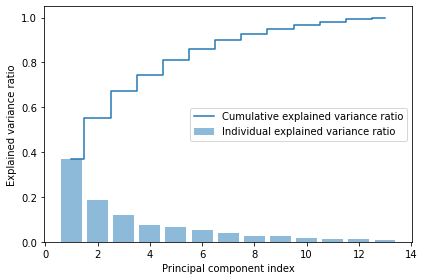

In [8]:
import matplotlib.pyplot as plt

plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='Individual explained variance ratio')
plt.step(range(1, 14), cum_var_exp, where='mid', label='Cumulative explained variance ratio')

plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### 특성 변환 

In [9]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [10]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('투영 행렬 W:\n', w)

투영 행렬 W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


$$\mathbf{z}=\mathbf{x}\mathbf{W}$$

In [11]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

$$\mathbf{Z}=\mathbf{X}\mathbf{W}$$

In [12]:
X_train_pca = X_train_std.dot(w)

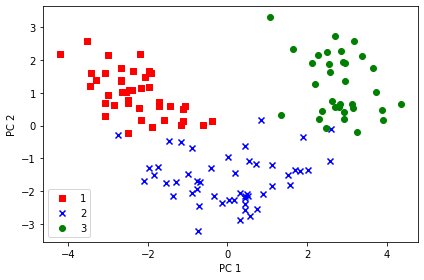

In [13]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], X_train_pca[y_train==l, 1], label=l, c=c, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### 사이킷런의 주성분 분석 

In [14]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    # 마커와 컬러맵을 설정합니다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1], 
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')


In [15]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
lr = LogisticRegression(random_state=1)

In [16]:
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr.fit(X_train_pca, y_train)

LogisticRegression(random_state=1)

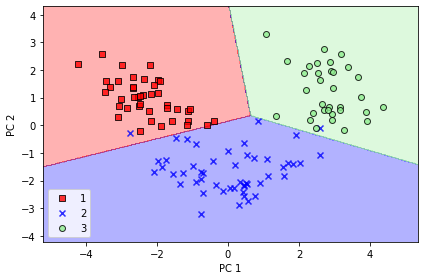

In [17]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

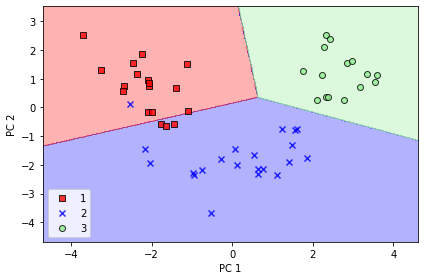

In [18]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

---

In [19]:
pca = PCA(n_components=None)  # n_components=None 으로 지정하면 차원 축소를 수행하는 대신 분산의 크기로 주성분이 반환됨

X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

In [20]:
pca = PCA(n_components=0.95)
pca.fit(X_train_std)

print('주성분 개수:', pca.n_components_)
print('설명된 분산 비율:', np.sum(pca.explained_variance_ratio_))

주성분 개수: 10
설명된 분산 비율: 0.9662714406558744


In [21]:
pca = PCA(n_components='mle')
pca.fit(X_train_std)

print('주성분 개수:', pca.n_components_)
print('설명된 분산 비율:', np.sum(pca.explained_variance_ratio_))

주성분 개수: 9
설명된 분산 비율: 0.9499753029186234


In [22]:
from sklearn.decomposition import IncrementalPCA

ipca = IncrementalPCA(n_components=9)
for batch in range(len(X_train_std) // 25 + 1):
    X_batch = X_train_std[batch * 25:(batch + 1) * 25]
    ipca.partial_fit(X_batch)

print('주성분 개수:', ipca.n_components_)
print('설명된 분산 비율:', np.sum(ipca.explained_variance_ratio_))

주성분 개수: 9
설명된 분산 비율: 0.9478392700446663


## 5.2 선형 판별 분석을 통한 지도 방식의 데이터 압축 

### 주성분 분석 vs. 선형 판별분석

* PCA - 비지도 학습
* LDA - 지도 학습

\begin{align*}
 J &= \frac{\mathbf{w}^T \mathbf{S}_B \mathbf{w}}{\mathbf{w}^T \mathbf{S}_W \mathbf{w}}\\
 &\Downarrow \\
 \mathbf{S}_B \mathbf{w} &= \lambda \mathbf{S}_W \mathbf{w} \\
 \mathbf{S}_W^{-1} \mathbf{S}_B \mathbf{w} &= \lambda \mathbf{w}
\end{align*}

[참고문헌](https://bit.ly/2A6AEKh)

In [23]:
Image(url='https://git.io/Jtsv8', width=400) 

### 선형 판별 분석의 내부 동작 방식

1. $d$차원의 데이터셋을 표준화 전처리
2. 각 클래스에 대해 $d$차원의 평균 백터를 계산
3. 클래스 간의 산포 행렬(scatter matrix) $\mathbf{S}_B$와 클래스 내 산포 행렬 $\mathbf{S}_w$를 구성
4. $\mathbf{S}_W^{-1}\mathbf{S}_B$ 행렬의 고유 백터와 고윳값을 계산
5. 고윳값을 내림차순으로 정렬하여 고유 백터의 순서를 매김
6. 고윳값이 가장 큰 $k$개의 고유 백터를 선택하여 $d \times k $ 차원의 변환 행렬 $\mathbf{W}$를 구성
7. 변환 행렬 $\mathbf{W}$를 사용하여 샘플을 새로운 특성 부분 공간으로 투영

### 산포 행렬 계산 

$$\mathbf{m}_i = \frac{1}{n_i} \sum_{\mathbf{x}\in D_i} \mathbf{x}$$

In [24]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



\begin{align*}
 \mathbf{S}_i = \sum_{\mathbf{x}\in D_i} &(\mathbf{x} -\mathbf{m}_i)^T(\mathbf{x} -\mathbf{m}_i)\\
 &\Downarrow \\
 \mathbf{S}_W &= \sum_{i=1}^c \mathbf{S}_i
\end{align*} 

In [25]:
d = 13  # 특성 개수

S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row -mv).T)
    S_W += class_scatter
    
print('클래스 내의 산포 행렬: %sx%s' % (S_W.shape[0], S_W.shape[1]))

클래스 내의 산포 행렬: 13x13


In [26]:
print('클래스 레이블 분포: %s' % np.bincount(y_train)[1:])

클래스 레이블 분포: [41 50 33]


$$\Sigma_i = \frac{1}{n_i}\mathbf{S}_i = \frac{1}{n_i} \sum_{\mathbf{x}\in D_i} (\mathbf{x} -\mathbf{m}_i)^T(\mathbf{x} -\mathbf{m}_i)$$

In [27]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
    
print('스케일 조정된 클래스 내의 산포 행렬: %sx%s' % (S_W.shape[0], S_W.shape[1]))

스케일 조정된 클래스 내의 산포 행렬: 13x13


$$\mathbf{S}_B = \sum_{i=1}^c n_i (\mathbf{m}_i -\mathbf{m})^T(\mathbf{m}_i -\mathbf{m})$$

In [28]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)

S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train== i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
    
print('클래스 간의 산포 행렬: %sx%s' % (S_W.shape[0], S_W.shape[1]))

클래스 간의 산포 행렬: 13x13


### 새로운 특성 부분 공간을 위해 선형 판별 벡터 선택 

In [29]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

print('내림차순의 고윳값:\n')
for eigen_val in eigen_pairs:
    print(round(eigen_val[0], 3))

내림차순의 고윳값:

349.618
172.762
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


---

In [30]:
tot = sum(eigen_vals.real)

discr = [i / tot for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

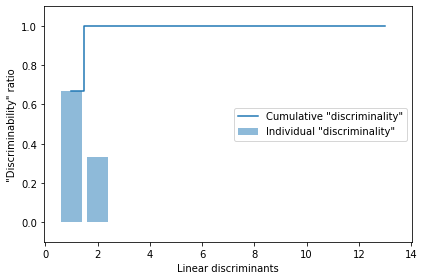

In [31]:
plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='Individual "discriminality"')
plt.step(range(1, 14), cum_discr, where='mid', label='Cumulative "discriminality"')

plt.xlabel('Linear discriminants')
plt.ylabel('"Discriminability" ratio')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [32]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))

print('행렬 W:\n', w)

행렬 W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


### 새로운 특성 공간으로 샘플 투영 

$$\mathbf{Z}=\mathbf{X}\mathbf{W}$$

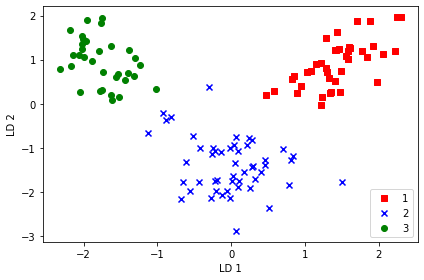

In [33]:
X_train_lda = X_train_std.dot(w) * -1

colors = ['r', 'b', 'g']
markers= ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1], c=c, label=l, marker=m)
    
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### 사이킷런의 LDA 

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

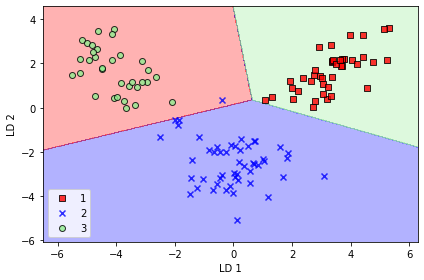

In [35]:
plot_decision_regions(X_train_lda, y_train, classifier=lr)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

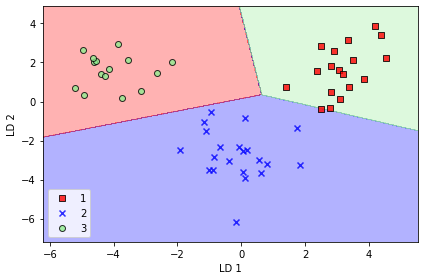

In [36]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

---

$$\begin{align*}
 \mathbf{m} &= \sum_{i=1}^c \frac{n_i}{n}\mathbf{m}_i\\ 
 \mathbf{S}_W &= \sum_{i=1}^c \frac{n_i}{n}\mathbf{S}_i = \sum_{i=1}^c \frac{n_i}{n} \Sigma_i
\end{align*}$$

In [37]:
y_uniq, y_count = np.unique(y_train, return_counts=True)
priors = y_count / X_train_std.shape[0]

priors

array([0.3306, 0.4032, 0.2661])

In [38]:
s_w = np.zeros((X_train_std.shape[1], X_train_std.shape[1]))
for i, label in enumerate(y_uniq):
    s_w += priors[i] * np.cov(X_train_std[y_train==label].T, bias=True)

$$\mathbf{S}_B = \sum_{i=1}^c \frac{n_i}{n} (\mathbf{m}_i -\mathbf{m})(\mathbf{m}_i -\mathbf{m})^T$$

In [39]:
s_b = np.zeros((X_train_std.shape[1], X_train_std.shape[1]))
for i, mean_vec in enumerate(mean_vecs):
    mean_vec = mean_vec.reshape(-1, 1)
    s_b += priors[i] * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

In [40]:
import scipy

ei_val, ei_vec = scipy.linalg.eigh(s_b, s_w)  #s_b w = lambda s_w w 
ei_vec = ei_vec[:, np.argsort(ei_val)[::-1]]

In [41]:
lda_eigen = LDA(solver='eigen')
lda_eigen.fit(X_train_std, y_train)

LinearDiscriminantAnalysis(solver='eigen')

In [42]:
np.allclose(s_w, lda_eigen.covariance_) # 클래스 내 산포행렬

True

$$\mathbf{S}_T = \frac{1}{n}\sum_{i=1}^c (\mathbf{x} -\mathbf{m})(\mathbf{x} -\mathbf{m})^T=\mathbf{S}_B +\mathbf{S}_W$$

In [43]:
Sb = np.cov(X_train_std.T, bias=True) - lda_eigen.covariance_
np.allclose(Sb, s_b)

True

In [44]:
np.allclose(lda_eigen.scalings_[:, :2], ei_vec[:, :2])

True

In [45]:
np.allclose(lda_eigen.transform(X_test_std), np.dot(X_test_std, ei_vec[:, :2]))

True

## 5.3 커널 PCA를 사용하여 비선형 매핑 

In [46]:
Image(url='https://git.io/JtsvB', width=500)

### 커널 함수와 커널 트릭 

\begin{align*}
 \hat{\Sigma} &= \sum_{i=1}^n \mathbf{x}^{(i)}{\mathbf{x}^{(i)}}^T  \\
 \\ 
 &\Downarrow \text{ Kernel Trick: } \phi: \mathbb{R}^d \rightarrow \mathbb{R}^k, \;\; k \gg d\\ 
 \\
 \hat{\Sigma} &=  \sum_{i=1}^n \phi\left( \mathbf{x}^{(i)} \right) \phi\left(\mathbf{x}^{(i)} \right ){}^T 
 =  \phi(\mathbf{X})^T \phi(\mathbf{X})\\
 &\Downarrow \\ 
 \hat{\Sigma} \mathbf{v} &= \lambda \mathbf{v},\;\;\mathbf{v}= \sum_{i=1}^n a^{(i)} \phi\left( \mathbf{x}^{(i)} \right)=\phi\left(\mathbf{X} \right)^T \mathbf{a}\\ 
 &\Downarrow \\ 
 \phi(\mathbf{X})^T \phi(\mathbf{X}) \phi\left(\mathbf{X} \right)^T \mathbf{a} &= \lambda \phi\left(\mathbf{X} \right)^T \mathbf{a} \\
 &\Downarrow \\
  \phi(\mathbf{X}) \phi(\mathbf{X})^T \phi(\mathbf{X}) \phi\left(\mathbf{X} \right)^T \mathbf{a} &= \lambda \phi(\mathbf{X}) \phi\left(\mathbf{X} \right)^T \mathbf{a} \\
 &\Downarrow \\
 \phi(\mathbf{X}) \phi(\mathbf{X})^T \mathbf{a} &= \lambda \mathbf{a} \\
 &\Downarrow \\
\mathbf{K} \mathbf{a} &= \lambda \mathbf{a}
\end{align*}

#### 샘플 $\mathbf{x}$ 끼리의 $\phi$ 함수 점곱을 커널 함수 $\mathbf{K}$로 

$$\kappa\left(\mathbf{x}^{(i)}, \mathbf{x}^{(j)} \right) = \phi \left( \mathbf{x}^{(i)} \right)^T \phi \left( \mathbf{x}^{(j)} \right)$$

#### 널리 사용되는 커널
$~$
* 다항 커널

$$\kappa\left(\mathbf{x}^{(i)}, \mathbf{x}^{(j)} \right) = \left( {\mathbf{x}^{(i)}}^T \mathbf{x}^{(j)} + \theta \right)^p$$

* 하이퍼볼릭 탄젠트(시그모이드) 커널

$$\kappa\left(\mathbf{x}^{(i)}, \mathbf{x}^{(j)} \right) = \tanh\left( \eta{\mathbf{x}^{(i)}}^T \mathbf{x}^{(j)} + \theta \right)$$

* 방사 기저 함수 또는 가우시안 커널

$$\kappa\left(\mathbf{x}^{(i)}, \mathbf{x}^{(j)} \right) = \exp\left( -\gamma\| \mathbf{x}^{(i)} -  \mathbf{x}^{(j)}\|^2 \right)$$

#### 커널 PCA를 구현하기 위한 세 단계
$~$
1. 커널(유사도) 행렬 $\mathbf{K}$ 계산

\begin{align*}
 \kappa\left(\mathbf{x}^{(i)}, \mathbf{x}^{(j)} \right) &= \exp\left( -\gamma\| \mathbf{x}^{(i)} -  \mathbf{x}^{(j)}\|^2 \right)\\ 
 &\Downarrow \\
 \mathbf{K} &=
\begin{bmatrix}
 \kappa\left(\mathbf{x}^{(1)}, \mathbf{x}^{(1)} \right)  & \kappa\left(\mathbf{x}^{(1)}, \mathbf{x}^{(2)} \right)  & \cdots & \kappa\left(\mathbf{x}^{(1)}, \mathbf{x}^{(n)} \right) \\ 
\kappa\left(\mathbf{x}^{(2)}, \mathbf{x}^{(1)} \right)  & \kappa\left(\mathbf{x}^{(2)}, \mathbf{x}^{(2)} \right)  & \cdots & \kappa\left(\mathbf{x}^{(2)}, \mathbf{x}^{(n)} \right) \\ 
 \vdots & \vdots & \ddots & \vdots\\ 
 \kappa\left(\mathbf{x}^{(n)}, \mathbf{x}^{(1)} \right) & \kappa\left(\mathbf{x}^{(n)}, \mathbf{x}^{(2)} \right)  & \cdots & \kappa\left(\mathbf{x}^{(n)}, \mathbf{x}^{(n)} \right)  
\end{bmatrix} 
\end{align*}

2. 커널 행렬 $\mathbf{K}$를 중앙에 맞춤

\begin{align*}
 \kappa_{ij}'=\kappa'\left(\mathbf{x}^{(i)}, \mathbf{x}^{(j)} \right) &= 
 \left( \phi\left( \mathbf{x}^{(i)} \right) - \frac{1}{n} \sum_{r=1}^n \phi\left( \mathbf{x}^{(r)} \right) \right)^T
 \left( \phi\left( \mathbf{x}^{(j)} \right) - \frac{1}{n} \sum_{s=1}^n \phi\left( \mathbf{x}^{(s)} \right) \right)
 \\ 
 &= \kappa_{ij} -\frac{1}{n} \left( \kappa_{1j} +\kappa_{2j}+\cdots+\kappa_{nj} \right)
-\frac{1}{n} \left( \kappa_{i1} +\kappa_{i2}+\cdots+\kappa_{in} \right)
+\frac{1}{n^2} \left( \kappa_{11} +\kappa_{12}+\cdots+\kappa_{nn} \right)
\\ 
 &\Downarrow \\ 
 \mathbf{K}' &= \mathbf{K} -\frac{1}{n} \mathbf{I} \mathbf{K} -\frac{1}{n} \mathbf{K} \mathbf{I}
+\frac{1}{n^2} \mathbf{I}\mathbf{K} \mathbf{I}
\end{align*}

3. 고윳값의 크기대로 내림차순으로 정렬하여 중앙에 맞춘 커널 행렬에서 최상위 $k$개의 고유 백터를 고름
  
   표준 PCA와 다르게 이렇게 선정된 고유백터는 주성분 축이 아니며, 이미 이 축에 투영된 샘플임




### 파이썬으로 커널 PCA 구현 

* [scipy.spatial.distance.pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html?highlight=pdist#scipy.spatial.distance.pdist)

* [scipy.spatial.distance.squareform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html#scipy.spatial.distance.squareform)

* [scipy.linalg.eigh](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigh.html)

In [47]:
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh

def rbf_kernel_pca(X, gamma, n_components):
    
    sq_dists = pdist(X, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dists)
    
    K = np.exp(-gamma * mat_sq_dists)
    
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    
    K = K -one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    
    X_pc = np.column_stack([eigvecs[:, i] for i in range(n_components)])
    
    return X_pc
    

---

예제 1: 반달 모양 구분하기

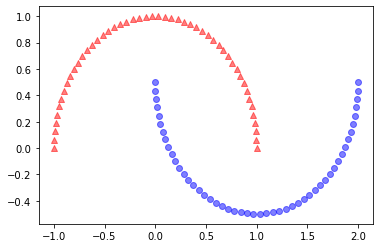

In [48]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.show()

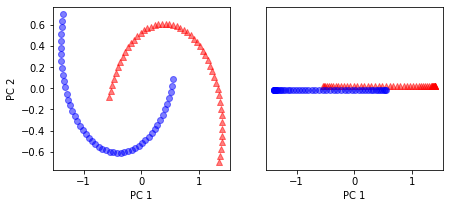

In [49]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y==0, 0], np.zeros((50, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((50, 1)) - 0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC 1')
ax[0].set_ylabel('PC 2')

ax[1].set_ylim([-0.8, 0.8])
ax[1].set_yticks([])
ax[1].set_xlabel('PC 1')

plt.show()

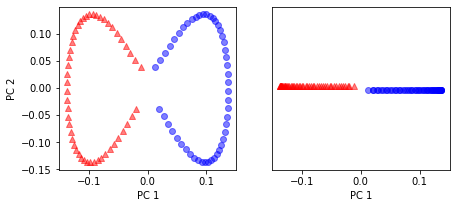

In [50]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50, 1)) - 0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC 1')
ax[0].set_ylabel('PC 2')

ax[1].set_ylim([-0.8, 0.8])
ax[1].set_yticks([])
ax[1].set_xlabel('PC 1')

plt.show()

---
예제 2: 동심원 분리하기

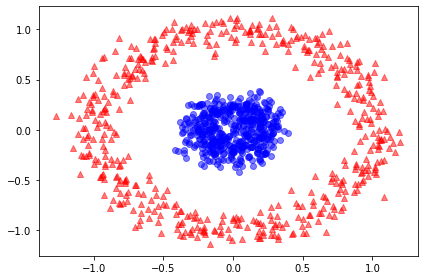

In [51]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.tight_layout()
plt.show()

In [52]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

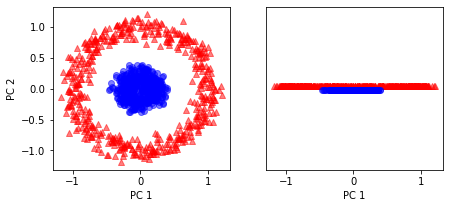

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y==0, 0], np.zeros((500, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((500, 1)) - 0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC 1')
ax[0].set_ylabel('PC 2')

ax[1].set_ylim([-0.8, 0.8])
ax[1].set_yticks([])
ax[1].set_xlabel('PC 1')

plt.show()

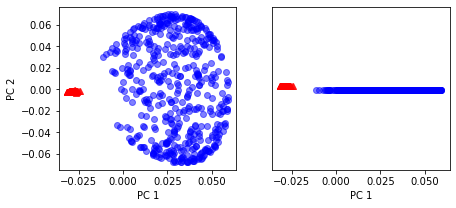

In [54]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((500, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500, 1)) - 0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC 1')
ax[0].set_ylabel('PC 2')

ax[1].set_ylim([-0.8, 0.8])
ax[1].set_yticks([])
ax[1].set_xlabel('PC 1')

plt.show()

### 새로운 데이터 포인트 투영 

\begin{align*}
 \phi\left(\mathbf{x}' \right)^T \mathbf{v} &= \sum_i a^{(i)}\phi\left( \mathbf{x}' \right)^T \phi\left( \mathbf{x}^{(i)} \right)\\ 
 &= \sum_i a^{(i)} \kappa\left( \mathbf{x}', \mathbf{x}^{(i)} \right) \\
&\Downarrow \\
\mathbf{K} \mathbf{a} &=\lambda \mathbf{a}
\end{align*}

In [55]:
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh

def rbf_kernel_pca(X, gamma, n_components):
    
    sq_dists = pdist(X, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dists)
    
    K = np.exp(-gamma * mat_sq_dists)
    
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    
    K = K -one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    
    alphas = np.column_stack([eigvecs[:, i] for i in range(n_components)])
    lambdas = [eigvals[i] for i in range(n_components)]
    
    return alphas, lambdas
    

In [56]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

In [57]:
x_new = X[25] # 새로운 데이터 포인트 x'로 가정
x_proj = alphas[25] # 원본 투영

print('x_new =', x_new)
print('x_proj =', x_proj)

x_new = [1.8713 0.0093]
x_proj = [0.0788]


In [58]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# 새로운 데이터포인트를 투영합니다.
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj

array([0.0788])

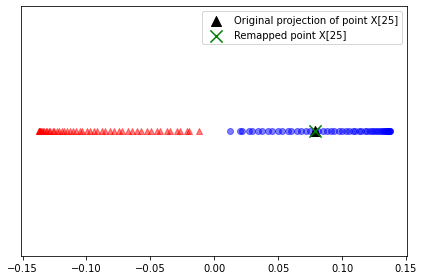

In [59]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)), color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)), color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black', label='Original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green', label='Remapped point X[25]', marker='x', s=150)
plt.yticks([], [])
plt.legend(scatterpoints=1)
plt.tight_layout()
plt.show()

### 사이킷런의 커널 PCA

In [60]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)

In [61]:
X_sckpca = scikit_kpca.fit_transform(X)

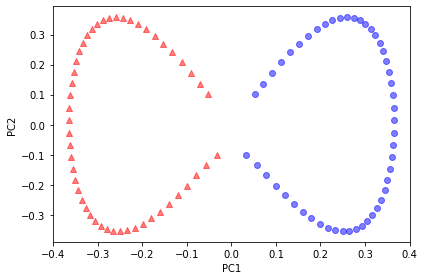

In [62]:
plt.scatter(X_sckpca[y == 0, 0], X_sckpca[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X_sckpca[y == 1, 0], X_sckpca[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

---
### 매니폴드 학습

In [63]:
def plot_manifold(X, y):
    
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.tight_layout()
    plt.show()

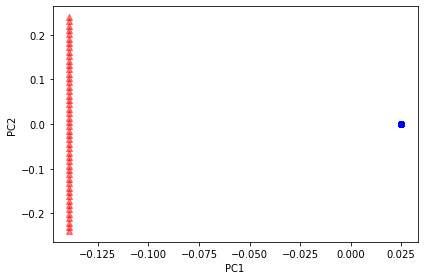

In [64]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, random_state=1)
X_lle = lle.fit_transform(X)

plot_manifold(X_lle, y)

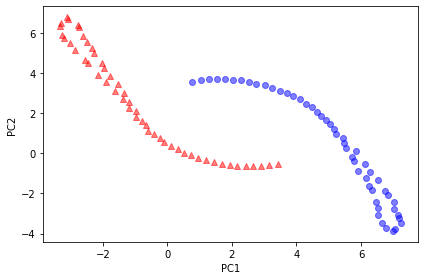

In [65]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X)

plot_manifold(X_tsne, y)

---

In [66]:
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

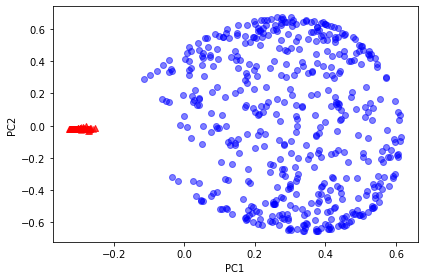

In [67]:
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_sckpca = scikit_kpca.fit_transform(X)

plot_manifold(X_sckpca, y)

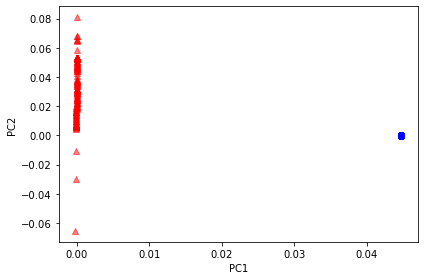

In [68]:
lle = LocallyLinearEmbedding(n_components=2, random_state=1)
X_lle = lle.fit_transform(X)

plot_manifold(X_lle, y)

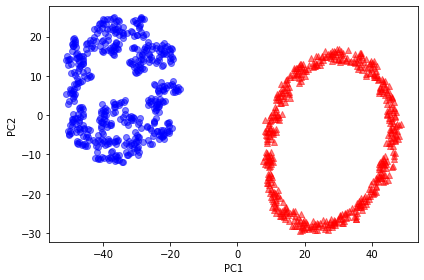

In [69]:
tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X)

plot_manifold(X_tsne, y)